# Search Engine for Wikipedia Articles Using Elastic Search

### Table of Contents:
- Section 1: Indexation <br><br>
- Section 2: Demonstration
    * Section 2.1: Language Model - Example Query
    * Section 2.2: BM25 Model - Example Query
    * Section 2.3 - Tf-idf Model: Example Query
    * Section 2.4: Search Engine Demo<br><br>
- Section 3: Importing Queries
    * Section 3.1: All Queries
    * Section 3.2: Query Length Distribution
    * Section 3.3: Document Length Distribution <br><br>
- Section 4: Defining Evaluation Model Rankings
  * Section 4.1 - Evaluation Metrics for Ranking Using 1 Example Query nDCG@5
  * Section 4.2 - Calculating Evaluation Metrics For All Queries - nDCG@5 and Precision@5
    * Section 4.2.1 - Evaluation Metrics For All Queries - nDCG@5 and Precision@5
    * Example Query Analysis
  * Section 4.3 - Retrieving Evaluation Metrics and Formatting Results<br><br>

- Section 5: Initial Evaluation of Models
    * Section 5.1: Comparisons of NDCG@5
    * Section 5.2: Comparisons of P@5<br><br>
- Section 6: BM25 Parameter Tuning
    * Section 6.1 - BM25 Creation Function
    * Section 6.2 - Create Indices with Different Parameters
    * Section 6.3 - Add Documents to Indices
    * Section 6.4 - nDCG Comparison Between 'match' and Boolean Queries with Different Parameters
    * Section 6.5 - Precision Comparison Between 'match' and Boolean Queries with Different Parameters
    * Section 6.6 - The Best Parameters
<br><br>
- Section 7 - Language Model - Optimisation
    * Section 7.1 - Evaluation of Language Models - NDCG@5 - Comparing 'match' with Boolean Queries
    * Section 7.2 - Evaluation of Language Models - P@5 - Comparing 'match' with Boolean Queries
    * Section 7.3 - Setting Alternative Lambda Values for JM Language Models
    * Section 7.4 - Comparing Alternative Lambda Values for JM Language Models
<br><br>
- Section 8 - Tf-idf - Optimisation
    * Section 8.1 - Comparison Between 'match' and Boolean Queries with Different Parameters
      * Section 8.1.1 nDCG
      * Section 8.1.2 - Precision
    * Section 8.2 - Standard tf-idf
    * Section 8.3 Standard tf-idf with document length normalisation
    * Section 8.4 Sublinear tf transformation
    * Section 8.5 Probabilistic inverse document frequency <br><br>
- Section 9 - Final Results

References


## Indexation

In [ ]:
!pip install elasticsearch

     |████████████████████████████████| 372 kB 8.3 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 138 kB 65.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import csv
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
from elasticsearch.helpers import streaming_bulk
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Creating and ElasticSearch client - Connecting to a local host

In [ ]:
es = Elasticsearch(
    cloud_id="cloud_id",
    http_auth=(["elastic", "password"])
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  This is separate from the ipykernel package so we can avoid doing imports until


> *certificate file path and password need to be adapted to file and authentication details on your system*

In [ ]:
es.info()

ObjectApiResponse({'name': 'instance-0000000001', 'cluster_name': '8a00e3b06fb74158868746907643074f', 'cluster_uuid': 'CnWJS4LPQP2uJQUjJfi-KA', 'version': {'number': '8.1.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '31df9689e80bad366ac20176aa7f2371ea5eb4c1', 'build_date': '2022-03-29T21:18:59.991429448Z', 'build_snapshot': False, 'lucene_version': '9.0.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Checking the downloaded training data

In [ ]:
#To access the data and run the code cells successfully, fully advise adding a shorcut to Google Drive with the contents of this link: https://drive.google.com/drive/folders/1Lg5eDNy6z4xrdMX8yDRM8ifho83fvJlO?usp=sharing

import pandas as pd
pd.read_csv('/content/drive/MyDrive/wikIR1k/documents.csv').head()

### Setting Similarity Settings & Preprocessing of Index - Language Model

Below, a function has been defined to create a Language Model index, specifying smoothing parameters and preprocessing steps.

In [ ]:
# The code below has been adapted from the Elasticsearch Guide [8.1] Similarity Module & Text Analysis, 2022
def generate_lm_index_for_docs(
                                es_index_name,
                                number_of_shards = 4,
                                number_of_replicas  = 1,
                                similarity_name = 'lm_similarity',
                                lm_smoothing_type = 'LMJelinekMercer',
                                lm_smoothing_lambda = 0.1,
                                stop_word_removal = True,
                                stemming = True
                                ):
    """
    Create language model index based on specified settings

    Uses logical operators to identify the components to be included
    in the settings and mappings of the index. Uses mapping
    settings required for the wikIR documents.

    Parameters
    ----------
    es_index_name : str
        Name to be given to new index
    number_of_shards : int, optional
        Number of shards to be used for the index, by default 4
    number_of_replicas : int, optional
        Number of replicas to be used for the index, by default 1
    similarity_name : str, optional
        Similarity name to be used in settings of the index. This
        can be arbitrary, but will need to be distinguishable,
        particularly from other language models using alternative
        settings, by default 'lm_similarity'
    lm_smoothing_type : str, optional
        Language Model smoothing type, by default 'LMJelinekMercer'
    lm_smoothing_lambda : float, optional
        Language Model lambda smoothing value, by default 0.1
    stop_word_removal : bool, optional
        Choice of whether or not to use stop word removal
        for measuring similarity, by default True
    stemming : bool, optional
        Choice of whether or not to use stemming removal
        for measuring similarity,, by default True

    Returns
    -------
    ObjectApiResponse or str
        API response confirming whether the index has been created
        or str stating the index already exists
    """

    lm_settings = {
                    'number_of_shards': number_of_shards,
                    'number_of_replicas': number_of_replicas,
                    'index' : {
                                'similarity' : {
                                                similarity_name : {
                                                                    'type' : lm_smoothing_type,
                                                                    'lambda' : lm_smoothing_lambda
                                                                    }
                                                }
                                }
                    }

    if stop_word_removal and stemming:
        analyser_settings =  {
                                'stop_word_removal' : {
                                                        'tokenizer' : 'whitespace',
                                                        'filter' : ['stop'],
                                                        'stopwords' : '_english_'
                                                        },
                                'stem'              :  {
                                                        'tokenizer' : 'whitespace',
                                                        'filter': ['stemmer']
                                                         }
                                }

        lm_settings['analysis'] =  analyser_settings

    elif stop_word_removal:
        analyser_settings =  {
                                'stop_word_removal' : {
                                                        'tokenizer' : 'whitespace',
                                                        'filter' : ['stop'],
                                                        'stopwords' : '_english_'
                                                        }
                                }
        lm_settings['analysis'] =  analyser_settings

    elif stemming:
        analyser_settings =  {
                                'stem'              :  {
                                                        'tokenizer' : 'whitespace',
                                                        'filter': ['stemmer']
                                                         }
                                }
        lm_settings['analysis'] =  analyser_settings

    else:
        pass

    lm_mappings = {
                    'properties': {
                                    'doc_text': {'type': 'text', 'similarity': similarity_name}
                                    }
                    }

    if es.indices.exists(index = es_index_name):
        return print('An index with the name {} already exists'.format(es_index_name))
    else:
        return es.indices.create(index = es_index_name, settings = lm_settings, mappings = lm_mappings)


The settings below have been outlined for the Language Model indexing. This includes the following:
- Stop Word Removal
- Stemming
- Similarity measured by a uni-gram Language Model with Jelinek Mercer smoothing.

The function above has been used to create a language model index with the smoothing parameter of lambda set to 0.1

In [ ]:
generate_lm_index_for_docs(
                                es_index_name = 'lm_index_lambda_0p1',
                                number_of_shards = 4,
                                number_of_replicas  = 1,
                                similarity_name = 'lm_similarity_lambda_0p1',
                                lm_smoothing_type = 'LMJelinekMercer',
                                lm_smoothing_lambda = 0.1,
                                stop_word_removal = True,
                                stemming = True
                                )

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'lm_index_lambda_0p1'})

The settings of the index are shown below.

In [ ]:
es.indices.get_settings(index = 'lm_index_lambda_0p1')

ObjectApiResponse({'lm_index_lambda_0p1': {'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '4', 'provided_name': 'lm_index_lambda_0p1', 'similarity': {'lm_similarity_lambda_0p1': {'type': 'LMJelinekMercer', 'lambda': '0.1'}}, 'creation_date': '1649709035555', 'analysis': {'stop_word_removal': {'filter': ['stop'], 'stopwords': '_english_', 'tokenizer': 'whitespace'}, 'stem': {'filter': ['stemmer'], 'tokenizer': 'whitespace'}}, 'number_of_replicas': '1', 'uuid': 'IAC0aBzFS4eH2PyNJAyTkQ', 'version': {'created': '8010199'}}}}})

In [ ]:
es.indices.get_mapping(index = 'lm_index_lambda_0p1')

ObjectApiResponse({'lm_index_lambda_0p1': {'mappings': {'properties': {'doc_text': {'type': 'text', 'similarity': 'lm_similarity_lambda_0p1'}}}}})

Now that the documents have been indexed, the queries will now be compared with the documents, checking for similarity and ranking the results.

### Taking documents from CSV file and inserting documents into an index

Below the ElasticSearch code bulk-ingest.py 2022 has been adapted to insert the downloaded documents into an index for the wikipedia articles.

In [ ]:
# Function adapted from ElasticSearch bulk-ingest.py 2022 and Elasticsearch v8.1.0 B.V Revision 2022 documentation.
# Code adapted to be made relevant

file_path = '/content/drive/MyDrive/wikIR1k/documents.csv'

def generate_actions():
    with open(file_path, mode="r") as f:
        reader = csv.DictReader(f)

        for row in reader:
            doc = {
                    "doc_text" : row["doc_text"],
                    "_id" : row["doc_id"]
                    }
            yield doc

Below the elasticsearch helpers bulk function has been used with the function that has retrieved documents from the CSV file.

In [ ]:
bulk(es, generate_actions(), index = 'lm_index_lambda_0p1', ignore_status = 400)

(369721, [])

> All 369,721 documents were added to the index, which has been named 'language_model_index'

Above the CSV file has been read and the elasticsearch helpers bulk function has been used create an index for the Wikipedia articles, inserting the document text for each document.

In [ ]:
pd.read_csv('/content/drive/MyDrive/wikIR1k/documents.csv').head()

,doc_id,doc_text
0,1781133,it was used in landing craft during world war ...
1,2426736,after rejecting an offer from cambridge univer...
2,2224122,mat zan coached kuala lumpur fa in 1999 and wo...
3,219642,a barcode is a machine readable optical label ...
4,1728654,since the subordination of the monarchy under ...


In [ ]:
es.search(index = 'lm_index_lambda_0p1', query = {'match_phrase' : {'doc_text' : 'landing craft during world war'}})

ObjectApiResponse({'took': 8, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 26.068209, 'hits': [{'_index': 'lm_index_lambda_0p1', '_id': '1781133', '_score': 26.068209, '_source': {'doc_text': 'it was used in landing craft during world war ii and is used today in private boats and training facilities the 6 71 is an inline six cylinder diesel engine the 71 refers to the displacement in cubic inches of each cylinder the firing order of the engine is 1 5 3 6 2 4 the engine s compression ratio is 18 7 1 with a 4 250 inch bore and a 5 00 inch stroke the engine weighs and is 54 inches long 29 inches wide and 41 inches tall at 2 100 revolutions per minute the engine is capable of producing 230 horse power 172 kilowatts v type versions of the 71 series were developed in 1957 the 6 71 is a two stroke engine as the engine will not naturally aspirate air is provided via a roots type blower ho

Above is a comparison between the csv file and the elasticsearch index using the text from one particular document. Match Phrase has been used as it is unlikely that more than one document would have this specific phrase.

### Setting Similarity Settings & Preprocessing of Index - BM25 Model

The settings below have been outlined for the Language Model indexing. This includes the following:
- Stop Word Removal
- Stemming
- Similarity measured by a BM25 model (hyperparameters discussed below).

In [ ]:
# The code below has been adapted from the Elasticsearch Guide [8.1] Similarity Module & Text Analysis, 2022
bm25_settings = {
                'number_of_shards': 4,
                'number_of_replicas': 1,
                'index' : {
                            'similarity' : {
                                            'bm25_similarity' : {
                                                                'type' : 'BM25',
                                                                'k1' : 1.2,
                                                                'b' : 0.75
                                                                }
                                            },
                            'analysis' : {
                                            'analyzer' : {
                                                            'stop_word_removal' : {
                                                                                    'tokenizer' : 'whitespace',
                                                                                    'filter' : ['stop'],
                                                                                    'stopwords' : '_english_'
                                                                                    },
                                                            'stem' :               {
                                                                                    'tokenizer' : 'whitespace',
                                                                                    'filter': ['stemmer']
                                                                                    }
                                                            }
                                            }
                                }
                }


In [ ]:
bm25_mappings = {
                'properties': {
                                'doc_text': {'type': 'text', 'similarity': 'bm25_similarity'}
                                }
                }

Below the BM25 indices have been created, the settings and mappings are displayed beneath also.

In [ ]:
es.indices.create(index = 'bm25_model_index', settings = bm25_settings, mappings = bm25_mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'bm25_model_index'})

In [ ]:
es.indices.get_settings(index = 'bm25_model_index')

ObjectApiResponse({'bm25_model_index': {'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '4', 'provided_name': 'bm25_model_index', 'similarity': {'bm25_similarity': {'type': 'BM25', 'b': '0.75', 'k1': '1.2'}}, 'creation_date': '1649709256060', 'analysis': {'analyzer': {'stop_word_removal': {'filter': ['stop'], 'stopwords': '_english_', 'tokenizer': 'whitespace'}, 'stem': {'filter': ['stemmer'], 'tokenizer': 'whitespace'}}}, 'number_of_replicas': '1', 'uuid': 'kucweh8LSAiEm9Bn3CCg3A', 'version': {'created': '8010199'}}}}})

Below the documents have been added to the BM25 index.

In [ ]:
bulk(es, generate_actions(), index = 'bm25_model_index', ignore_status = 400)

(369721, [])

> All 369,721 documents were added to the index, which has been named 'bm25_model_index'

### Setting Similarity Settings & Preprocessing of Index - Tf-idf Model

The settings below have been outlined for the tf-idf indexing. This includes the following:
- Stop Word Removal
- Stemming
- Similarity measured by a tf-idf model

Since the tf-idf model is not a default one in ElasticSearch, I am leveraging a custom similarity to customize our formula.


In [ ]:
std_tfidf = "double tf = doc.freq; double idf = Math.log((field.docCount+1.0)/(term.docFreq+1.0)) + 1.0; double norm = 1/Math.sqrt(doc.length); return tf * idf ;"

In [ ]:
tfidf_body = {
  "settings": {
    "number_of_shards": 4,
    "number_of_replicas"  : 1,
    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": std_tfidf
        }
      }
    },
                                      'analysis' : {
                                            'analyzer' : {
                                                            'stop_word_removal' : {
                                                                                    'tokenizer' : 'whitespace',
                                                                                    'filter' : ['stop'],
                                                                                    'stopwords' : '_english_'
                                                                                    },
                                                            'stem' :               {
                                                                                    'tokenizer' : 'whitespace',
                                                                                    'filter': ['stemmer']
                                                                                    }
                                                            }
                                            }
  }

}



tfidf_mappings = {
                'properties': {
                                'doc_text': {'type': 'text', 'similarity': 'scripted_tfidf'}
                                }
                }




es.indices.create(index = 'tf_idf', body = tfidf_body,mappings=tfidf_mappings, ignore=[400, 404])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'tf_idf'})

Below the documents have been added to the tf-idf index.

In [ ]:
bulk(es, generate_actions(), index = 'tf_idf', ignore_status = 400)

(369721, [])

## Section 2: Demonstration

### Section 2.1: Language Model - Example Query

Example Query:
- Below the 'query' term 'football' has been searched for in the collection of documents to check if the returned documents are appropriate.

In [ ]:
example_results_lm = es.search(index = 'lm_index_lambda_0p1', query = {'match' : {'doc_text' : 'football'}})['hits']['hits']

In [ ]:
example_results_lm[0]

{'_id': '1428048',
 '_index': 'lm_index_lambda_0p1',
 '_score': 7.6730213,
 '_source': {'doc_text': 'unqualified the word football normally means the form of football that is the most popular where the word is used sports commonly called football include association football known as soccer in some countries gridiron football specifically american football or canadian football australian rules football rugby football either rugby league or rugby union and gaelic football these various forms of football are known as football codes there are a number of references to traditional ancient or prehistoric ball games played in many different parts of the world contemporary codes of football can be traced back to the codification of these games at english public schools during the nineteenth century the expansion of the british empire allowed these rules of football to spread to areas of british influence outside the directly controlled empire by the end of the nineteenth century distinct regi

### Section 2.2 - BM25 Model: Example Query

Example Query:
- Below the 'query' term 'football' has been searched for in the collection of documents to check if the returned documents are appropriate.

In [ ]:
example_results_bm25 = es.search(index = 'bm25_model_index', query = {'match' : {'doc_text' : 'football'}})['hits']['hits']

In [ ]:
example_results_bm25[0]


{'_index': 'bm25_model_index',
 '_id': '1428048',
 '_score': 6.7784696,
 '_source': {'doc_text': 'unqualified the word football normally means the form of football that is the most popular where the word is used sports commonly called football include association football known as soccer in some countries gridiron football specifically american football or canadian football australian rules football rugby football either rugby league or rugby union and gaelic football these various forms of football are known as football codes there are a number of references to traditional ancient or prehistoric ball games played in many different parts of the world contemporary codes of football can be traced back to the codification of these games at english public schools during the nineteenth century the expansion of the british empire allowed these rules of football to spread to areas of british influence outside the directly controlled empire by the end of the nineteenth century distinct regiona

The highest ranked document contains repeated mentions of the term 'football' giving reason for the appearance of this document first.

In addition to standard 'match', boolean queries will also be searched, a potential example is shown below. Specifying 'should' instead of 'must' is equivalent to enabling an OR logical operator instead of AND, which influence the search results as shown below. For long queries the percentage of query terms required to match a term can be controlled, which will affect the number of documents retrieved as shown below.

In [ ]:
es.search(
            index = 'bm25_model_index',
            query = {
                    'bool' : {
                                'must' : [
                                                {'term' : {'doc_text' : 'football'}},
                                                {'term' : {'doc_text' : 'rugby'}},
                                                {'term' : {'doc_text' : 'pink'}}
                                                ]
                                }
                        }
            )

ObjectApiResponse({'took': 1629, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 18.800447, 'hits': [{'_index': 'bm25_model_index', '_id': '1641690', '_score': 18.800447, '_source': {'doc_text': 'the team plays oxford university rfc in the annual varsity match at twickenham stadium every december cambridge players wear light blue and white hooped jerseys with a red lion crest many have gone on to represent their country and the british and irish lions a few most notably dan vickerman james horwill flip van der merwe have represented cambridge after successful international careers while at cambridge university james bevan became the first captain of the wales national rugby union team the curufc stadium is located in west cambridge beside grange road football is believed to have been introduced to cambridge university in 1839 by trinity college fresher albert pell pell had matriculat

Using the boolean option 'must' (equivalent to specifying AND for all terms in the query) narrowed the search results and found the only article in the training data with the terms 'football, 'rugby' and 'pink'. During evaluation, boolean query results will be reviewed to see how they affect evaluation metrics.

### Section 2.3 - Tf-idf Model: Example Query

Example Query:
- Below the 'query' term 'football' has been searched for in the collection of documents to check if the returned documents are appropriate.

In [ ]:
example_results_tfidf = es.search(index = 'tf_idf', query = {'match' : {'doc_text' : 'football'}})['hits']['hits']

In [ ]:
example_results_tfidf[0]

{'_id': '1428048',
 '_index': 'tf_idf',
 '_score': 81.26891,
 '_source': {'doc_text': 'unqualified the word football normally means the form of football that is the most popular where the word is used sports commonly called football include association football known as soccer in some countries gridiron football specifically american football or canadian football australian rules football rugby football either rugby league or rugby union and gaelic football these various forms of football are known as football codes there are a number of references to traditional ancient or prehistoric ball games played in many different parts of the world contemporary codes of football can be traced back to the codification of these games at english public schools during the nineteenth century the expansion of the british empire allowed these rules of football to spread to areas of british influence outside the directly controlled empire by the end of the nineteenth century distinct regional codes wer

### Section 2.4 - Demonstration of Search Engine Process (Example - To be adapted for final models)

Below a function has been defined to retrieve the top k documents from a specified index given a query.

In [ ]:
def get_top_k_ranked_search_results(
                                    query_check,
                                    es_index,
                                    k,
                                    match_type = 'match',
                                    boolean_query_option = 'should',
                                    minimum_should_match = 1
                                    ):
    """
    Show top k ranked documents for a specified query.

    Searches specified index and returns top k ranked results in
    a Dataframe.

    Parameters
    ----------
    query_check : str
        The query being checked.
    es_index : str
        The elastic search index being checked.
    k : int
        The number of top of results to return.
    match_type : str
        Match type to use for the queries, by default 'match'.
    boolean_query_option : str
        Option specifying how terms in boolean query are matched
        such as 'should' or 'must', by default 'should'.
    minimum_should_match : int or str
        Number of query terms or percentage that should match
        terms in the documents if boolean_query_option
        is set to 'should' (Elasticsearch Guide [8.1], 2022). If
        percentage, should be entered as str e.g. '75%', by default 1.

    Returns
    -------
    pandas.Dataframe
        Table containing the the document IDs and similarity scores of
        top K ranked documents for the specified query.
    """
    if match_type == 'bool' and boolean_query_option == 'should':
        query_terms = query_check.split()
        query_given_match_type = {
                                    match_type: {
                                                boolean_query_option : [
                                                                        {'term' : {'doc_text' : term}}\
                                                                        for term in query_terms
                                                                        ],
                                                'minimum_should_match' : minimum_should_match
                                                }
                                    }
    elif match_type == 'bool' and boolean_query_option == 'must':
        query_terms = query_check.split()
        query_given_match_type = {
                                    match_type: {
                                                boolean_query_option : [
                                                                        {'term' : {'doc_text' : term}}\
                                                                        for term in query_terms
                                                                        ]
                                                }
                                    }
    else:
        query_given_match_type  = {match_type : {'doc_text' : query_check}}

    es_search_results = es.search(index = es_index, query = query_given_match_type)['hits']['hits']
    doc_ids_and_scores = []
    query_result_dict = {query_check : doc_ids_and_scores}

    for search_result in es_search_results[:k]:
        doc_ids_and_scores.append([search_result['_id'], search_result['_score']])

    # convert list of lists to an array to be used for a dataframe
    query_result_dict[query_check] = np.array(doc_ids_and_scores, ndmin = 2)
    print("Top Ranked Results for the Query: \n'{}'".format(query_check))
    return pd.DataFrame(query_result_dict[query_check], columns = ['doc_id', 'similarity_score'])

Below an example query 'cooking' has been searched for in each index.

In [ ]:
get_top_k_ranked_search_results(query_check = 'cooking', es_index = 'lm_index_lambda_0p1', k = 10)

Top Ranked Results for the Query: 
'cooking'


,doc_id,similarity_score
0,2131001,9.771462
1,515334,9.722675
2,1503229,9.722204
3,196153,9.715552
4,569454,9.670914
5,1813375,9.649467
6,1760149,9.548333
7,428522,9.548333
8,323126,9.548333
9,2362275,9.535089


The function below retrieves the text for the top ranked documents (by default it is set to show the highest result alone, but can be adapted to show more). Below, it has been used to show the corresponding text to the the top result's ID.

In [ ]:
def show_top_search_result_text(
                                query_check,
                                es_index,
                                k = 1,
                                match_type = 'match',
                                boolean_query_option = 'should',
                                minimum_should_match = 1
                                ):
    """
    Show text for top search results for query.

    Uses the get_top_k_ranked_search_results function and
    looks up the corresponding text from documents using
    their IDs, which are found in the documents file.

    Parameters
    ----------
    query_check : str
        The query being checked.
    es_index : str
        The elastic search index being checked.
    k : int
        The number of top of results to return.
    match_type : str
        Match type to use for the queries, by default 'match'.
    boolean_query_option : str
        Option specifying how terms in boolean query are matched
        such as 'should' or 'must', by default 'should'.
    minimum_should_match : int or float
        Number of query terms or proportion that should match
        terms in the documents if boolean_query_option
        is set to 'should', by default 1.

    Returns
    -------
    pandas.Series of Object
        document text of top search results for given index
        and query.
    """
    docs_file_path = '/content/drive/MyDrive/wikIR1k/documents.csv'
    df = get_top_k_ranked_search_results(
                                            query_check,
                                            es_index,
                                            k = k,
                                            match_type = match_type,
                                            boolean_query_option = boolean_query_option,
                                            minimum_should_match = minimum_should_match
                                            )

    # Update data type of doc_id to int (from str) to match data type of doc_id in documents file.
    ids_of_top_docs = df.doc_id.astype({'doc_id' : 'int32'})

    return pd.read_csv(docs_file_path, index_col = 'doc_id').loc[ids_of_top_docs, 'doc_text']

Example search from the Language Model index:

In [ ]:
show_top_search_result_text(query_check = 'cooking', es_index = 'lm_index_lambda_0p1', match_type = 'match').item()

Top Ranked Results for the Query: 
'cooking'


'he has been a michelin starred chef since 1990 his light and colorful cooking is permeated with north south mixtures thanks to his european and asiatic career according to him cooking is done with eco friendly and healthy products it needs to be shared he has written in magazines and english newspapers published books and hosted cooking shows on the bbc daniel galmiche loves cooking since its earliest years this love appeared through healthy and natural products from his grandparents farm from hunting with his father as well as fragrances from his mother cooking he apprenticed at the gourmet restaurant of chef yves lalloz luxeuil les bains he improved his work in la napoule in the south of france then abroad in sweden singapore and portugal in 1977 daniel galmiche practised in london with the help of the great french chef michel roux he was elected chef of the 1987 1988 season in scotland during the 1989 1990 season he got the michelin star at knockingam lodge hotel he joined the harv

> When k  is set to 1, the .item() function can be used with the returned output to show full text of the document in first position of the query results.

Example search from the BM25 index:

In [ ]:
show_top_search_result_text(query_check = 'cooking', es_index = 'bm25_model_index', match_type = 'match').item()

Top Ranked Results for the Query: 
'cooking'


'he has been a michelin starred chef since 1990 his light and colorful cooking is permeated with north south mixtures thanks to his european and asiatic career according to him cooking is done with eco friendly and healthy products it needs to be shared he has written in magazines and english newspapers published books and hosted cooking shows on the bbc daniel galmiche loves cooking since its earliest years this love appeared through healthy and natural products from his grandparents farm from hunting with his father as well as fragrances from his mother cooking he apprenticed at the gourmet restaurant of chef yves lalloz luxeuil les bains he improved his work in la napoule in the south of france then abroad in sweden singapore and portugal in 1977 daniel galmiche practised in london with the help of the great french chef michel roux he was elected chef of the 1987 1988 season in scotland during the 1989 1990 season he got the michelin star at knockingam lodge hotel he joined the harv

The language model and BM25 model retrieved the same document in first position for the query cooking, demonstrating similarities of interpretations of what is relevant. This may change based on the match type and hyperparameters of the index, which is addressed in the following sections.

An example boolean query is shown below.

In [ ]:
show_top_search_result_text(
                                query_check = 'rugby football pink',
                                es_index = 'bm25_model_index',
                                k = 10,
                                match_type = 'bool',
                                boolean_query_option = 'should',
                                minimum_should_match = '60%'
                                )

Top Ranked Results for the Query: 
'rugby football pink'


doc_id
1641690    the team plays oxford university rfc in the an...
10792      rugby split into two sports in 1895 when twent...
1473373    aside from american football rugby league is t...
1648428    a second code clash featuring st helens and sa...
308356     although the cfl was not founded until 1958 th...
228325     it was officially constituted in 1949 and is a...
454183     although the cfl was not founded until 1958 th...
1252899    it began in australia in 1907 when the new sou...
781668     their senior representative team compete in th...
530425     thomas rugby football club gkt is the name giv...
Name: doc_text, dtype: object

> entering 'minimum_should_match' as '100%' is equivalent to entering 'must' as the boolean option, which corresponds to using AND in the query for all terms.

## Section 3 - Importing Queries - Training Data

### Section 3.1 -  All Queries

#### Importing Queries From Training Data

In [ ]:
qrels_df  = pd.read_csv('/content/drive/MyDrive/wikIR1k/training/training_qrels.csv', index_col = 'query_id'
)
queries_df = pd.read_csv('/content/drive/MyDrive/wikIR1k/training/training_queries.csv', index_col = 'query_id'
                         )

Query Relevance Scores (Ground Truths)

In [ ]:
qrels_df.head()

,doc_id,doc_relevance_given_query
query_id,,
123839,123839,2
123839,1793430,1
123839,806300,1
123839,806075,1
123839,836567,1


In [ ]:
queries_df.head()

,query_text
query_id,
123839,yanni
188629,k pop
13898,venice film festival
316959,downtown brooklyn
515031,pennsylvania house of representatives


### Section 3.2 - Query Length Distribution

To see how queries of different lengths may affect the retrieval of relevant documents, below, queries have been categorised by their length.

In [ ]:
# Remove whitespace from the beginning and end of a string
queries_df = queries_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# count words and add as column
queries_df['query_length']  = queries_df['query_text'].apply(lambda x: len(x.split()))
queries_df.head()

,query_text,query_length
query_id,,
123839,yanni,1
188629,k pop,2
13898,venice film festival,3
316959,downtown brooklyn,2
515031,pennsylvania house of representatives,4


Text(0, 0.5, 'Number of Queries')

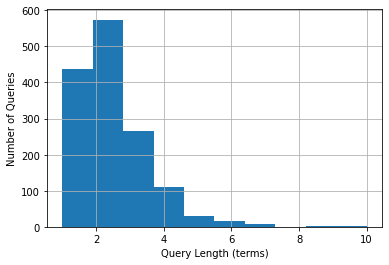

In [ ]:
ax = queries_df['query_length'].hist()
ax.set_xlabel("Query Length (terms)")
ax.set_ylabel("Number of Queries")

In [ ]:
queries_df.query_length.describe()

count    1444.000000
mean        2.187673
std         1.187291
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: query_length, dtype: float64

From the table and histogram below, it is clear the majority of queries are 3 words long or shorter.

### Section 3.3 - Document Length Distribution

In this section we'll take a look at the distribution of document lengths since the BM25 and TF-IDF models incorporate document normalization techniques.

In [ ]:
# save training docs to df
training_docs = pd.read_csv('/content/drive/MyDrive/wikIR1k/documents.csv')

training_docs.head()

,doc_id,doc_text
0,2222141,boat lift consists of the outer harbor the bot...
1,1466972,one highlight is its collection of fijnschilde...
2,1218994,their objective was to eliminate the presence ...
3,2087053,he was elected to basar constituency in the ye...
4,833090,developed from the earlier blue bonnet dating ...


Given that the created indices remove stopwords, we'll process the training text in the same way below.

In [ ]:
# vectorize documents
vectorizer = CountVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(training_docs['doc_text'])
vocabulary = vectorizer.get_feature_names_out()

The table shows the total number of words per document. For example, the first document has 70 words, the second document has 112 words, etc.

In [ ]:
# Make df of document lengths
training_docs_lengths = training_docs.drop(columns=['doc_text'])
training_docs_lengths['doc_length'] = (np.array(documents_vectorized.sum(axis=1))).flatten()
training_docs_lengths.head()

,doc_id,doc_length
0,2222141,70
1,1466972,112
2,1218994,105
3,2087053,99
4,833090,111


From the table below:
* Average terms per document: 107.29
* Standard deviation: 10.64
* Shortest document: 8 terms
* Longest document: 182 terms

In [ ]:
training_docs_lengths.describe()

,doc_id,doc_length
count,4.382400e+04,43824.000000
mean,1.187713e+06,107.287012
std,7.078682e+05,10.641314
min,5.000000e+00,8.000000
25%,5.799928e+05,102.000000
50%,1.158835e+06,108.000000
75%,1.797272e+06,114.000000
max,2.456624e+06,182.000000


The histogram below shows a narrow distribution of document lengths centered around the mean of document lengths (107.29).

Text(0, 0.5, 'Number of Documents')

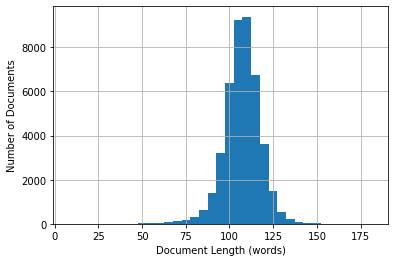

In [ ]:
ax = training_docs_lengths['doc_length'].hist(bins=35)
ax.set_xlabel("Document Length (words)")
ax.set_ylabel("Number of Documents")

## Section 4 - Defining Evaluation Model Rankings

### Section 4.1: Evaluation Metrics For Ranking Using 1 Example Query - NDCG@5

Below a function has been defined to return the most relevant documents for a query from the dataframe containing the ground truth labels for relevance. This will be used to compare the search results for each model.

In [ ]:
def get_true_relevant_docs_for_query(query_id):
    """
    Get the relevant documents and true relevance labels for a query.

    Parameters
    ----------
    query_id : int
        query ID corresponding to queries in the
        queries dataframe and query relevance (qrels) dataframe.

    Returns
    -------
    pandas.Dataframe
        Datafrae containing the IDs of the truly relevant documents
        for the query and their relevance labels.
    """
    true_relevant_docs_for_query_df = qrels_df.loc[query_id]
    query = queries_df.loc[query_id, 'query_text']
    print("Ground truth relevance labels of documents for the query '{}':".format(query))
    return true_relevant_docs_for_query_df

In [ ]:
# example query ID from the queries dataframe
yanni_query_id = 123839

get_true_relevant_docs_for_query(yanni_query_id)

Ground truth relevance labels of documents for the query 'yanni':


,doc_id,doc_relevance_given_query
query_id,,
123839,123839,2
123839,1793430,1
123839,806300,1
123839,806075,1
123839,836567,1
123839,806263,1


Below, the first query, five relevant documents and their relevance label has been used to evaluate the ranking of the search for this query:
- Normalised Discounted Cumulative Gain has been calculated for the first 5 results (NDCG@5)

In [ ]:
ndcg_example_result_given_q = es.rank_eval(
                                        index = 'lm_index_lambda_0p1',
                                        requests = {
                                                        'id' : str(yanni_query_id),
                                                        'request' : {'query' : {
                                                                                'match' : {'doc_text' : 'yanni'}
                                                        },
                                                                },
                                                        # doc IDs below taken from qrels df only for this particular example
                                                        'ratings': [
                                                                { '_index': 'lm_index_lambda_0p1', '_id': '123839', 'rating': 2 },
                                                                { '_index': 'lm_index_lambda_0p1', '_id': '1793430', 'rating': 1 },
                                                                { '_index': 'lm_index_lambda_0p1', '_id': '806300', 'rating': 1 },
                                                                { '_index': 'lm_index_lambda_0p1', '_id': '806075', 'rating': 1 },
                                                                { '_index': 'lm_index_lambda_0p1', '_id': '836567', 'rating': 1 }
                                                                ]
                                                        },
                                        metric = {
                                                        'dcg': {
                                                                'k': 5,
                                                                'normalize': True
                                                                }
                                                        }

                                        )
ndcg_example_result_given_q = dict(ndcg_example_result_given_q)['details'][str(yanni_query_id)]['metric_details']
print("NDCG@5 metric details for the query 'yanni':\n{}".format(ndcg_example_result_given_q))

NDCG@5 metric details for the query 'yanni':
{'dcg': {'dcg': 3.178882481454721, 'ideal_dcg': 4.948459118879392, 'normalized_dcg': 0.6423984527479734, 'unrated_docs': 1}}


The value for NDCG@5 of 0.64 suggests that the documents ranked highest in the retrieval using the Language Model were mostly relevant, although the rankings could have been better, the most relevant documents could have been positioned higher, reflected by the difference between the DCG produced by the model (3.17) and the Ideal DCG given the ground truths (4.95).

The returned documents from the Language Model and the expected relevant documents given the query are shown below.

In [ ]:
get_top_k_ranked_search_results(query_check = 'yanni', es_index = 'lm_index_lambda_0p1', k = 5)

Top Ranked Results for the Query: 
'yanni'


,doc_id,similarity_score
0,806300,13.47165
1,806326,12.703196
2,836567,12.703196
3,123839,12.39447
4,1793430,11.883647


Given the ground truth labels, the documents that should have been returned first are shown below. The most relevant document (the doc_id 123839) was positioned in 4th place using the Language Model with its current hyperparameters. Alternative hyperparameters will be considered later.

In [ ]:
get_true_relevant_docs_for_query(yanni_query_id)

Ground truth relevance labels of documents for the query 'yanni':


,doc_id,doc_relevance_given_query
query_id,,
123839,123839,2
123839,1793430,1
123839,806300,1
123839,806075,1
123839,836567,1
123839,806263,1


Below, this process will be repeated for multiple queries, after the results will be aggregated to compare the evaluation metrics per model, taking into consideration potential adjustments of the hyperparameters.

### Section 4.2 - Calculating Evaluation Metrics For All Queries - NDCG@5 & Precision@5

Below the elasticsearch rank evaluation function has been used (similarly to above) with a for loop to be applicable to multiple queries. The results for all training queries from the list of queries have been stored and displayed below (a list of dictionaries has been used).
- Above, to check an example, query ID, doc ID and relevance scores were hard coded
- Below, they have been made variables to be updated in a for loop as the query relevance data is read row by row.

In [ ]:
def get_evaluation_metrics(
                            queries_df,
                            qrels_df,
                            es_index,
                            eval_metric_dict,
                            match_type = 'match',
                            boolean_query_option = 'should',
                            minimum_should_match = 1
                            ):
        """
        Check ground truth relevance and calculate ranking evaluation metric.

        Checks dataframes containing query text data, retrieves
        relevant documents and ground truth labels for those documents,
        and compares ranking generated by search to ideal ranking
        given the ground truth labels.

        Parameters
        ----------
        queries_df : pandas.DataFrame
            Dataframe containing query IDs and query text.
        es_index : str
            Name of the index to be used for the search.
        qrels_df : pandas.DataFrame
            Dataframe containing the ground truth relevance labels.
        eval_metric_dict : dict
            Dictionary containing the parameters of the evaluation metric
            such as k for NDCG@k.
        match_type : str
            Match type to use for the queries, by default 'match'.
        boolean_query_option : str
            Option specifying how terms in boolean query are matched
            such as 'should' or 'must', by default 'should'.
        minimum_should_match : int or float
            Number of query terms or proportion that should match
            terms in the documents if boolean_query_option
            is set to 'should', by default 1.

        Returns
        -------
        list of dict
            list of dictionaries mapping query IDs to the NDCG measure for the query.
        """

        # Store evaluation results in list
        eval_results = []

        for query_id in queries_df.index:

                query_text = queries_df.loc[query_id, 'query_text']

                # Ratings:
                # Create iterable from the qrels_df, which will be used for doc ratings per query.
                doc_qrels_given_query_id = qrels_df.loc[query_id].iterrows()

                # For ratings below, doc ID & qrel label from qrels_df rows have
                # been retrieved using list comprehension with the iterable created.
                ratings_list = [
                                {
                                '_index': es_index,
                                '_id': str(doc_row['doc_id']),
                                'rating': doc_row['doc_relevance_given_query']
                                }\
                                for _, doc_row in doc_qrels_given_query_id
                                 ]

                # Query:
                # set minimum_should number or percentage if 'should' is used.
                if match_type == 'bool' and boolean_query_option == 'should':
                    query_terms = query_text.split()
                    # specify boolean query options using list comprehension
                    query_given_match_type = {
                                    match_type: {
                                                boolean_query_option : [
                                                                        {'term' : {'doc_text' : term}}\
                                                                        for term in query_terms
                                                                        ],
                                                'minimum_should_match' : minimum_should_match
                                                }
                                    }

                # don't set minimum_should number or percentage if 'must' is used.
                elif match_type == 'bool' and boolean_query_option == 'must':
                    query_terms = query_text.split()
                    query_given_match_type = {
                                    match_type: {
                                                boolean_query_option : [
                                                                        {'term' : {'doc_text' : term}}\
                                                                        for term in query_terms
                                                                        ]
                                                }
                                    }
                else:
                    query_given_match_type  = {match_type : {'doc_text' : query_text}}

                # get evaluation results using ratings and query parameters above.
                eval_result = es.rank_eval(
                                            index = es_index,
                                            requests = {
                                                        'id' : str(query_id),
                                                        'request' : {'query' : query_given_match_type},
                                                        'ratings': ratings_list
                                                    },
                                            metric = eval_metric_dict
                                            )

                # store evaluation results as list of dictionaries
                eval_results.append({query_id : dict(eval_result)})

        return eval_results


#### Section 4.2.1 - Evaluation Metrics For All Queries From Training Data - NDCG@5

The parameters below will be used to calculate NDCG@5for a second example query, which is slightly longer.

In [ ]:
ndcg_at_k_metric = {
                        'dcg': {
                                'k': 5,
                                'normalize': True
                                }
                        }

In [ ]:
lm_ndcg_at_5_results = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = 'lm_index_lambda_0p1',
                                                eval_metric_dict = ndcg_at_k_metric,
                                                match_type = 'match'
                                                )

#### Example query evaluation analysis

Evaluation metrics for the second example query, 'k pop' are shown below (the first example 'yanni' has been discussed).
- The output of the elasticsearch command is a combination of lists and dictionaries
- The required results have been retrieved using lookups of those dictionaries and lists with the commands below.

In [ ]:
# NDCG @5 Evaluation results for the second query example
example_2_query_id = queries_df.index[1]
example_2_query_text = queries_df.loc[example_2_query_id, 'query_text']
print("Second Example Query: '{}'".format(example_2_query_text))

ndcg_for_example_2_query = lm_ndcg_at_5_results[1][example_2_query_id]['metric_score']
print("Normalised Discounted Cumulative Gain @ 5:\n{}".format(ndcg_for_example_2_query))

Second Example Query: 'k pop'
Normalised Discounted Cumulative Gain @ 5:
0.7337495705923307


The results for the query 'k pop' using the language model are better than those returned using the 'yanni', which could be related to the shorter query 'yanni' occurring in documents where it may not be the most important topic in the document, which may make retrieving irrelevant documents more likely, affecting the ranking of relevant documents. When assessing the hyperparamters of each model, the adaptability of models in relation to rare and short terms will be considered.

In [ ]:
get_top_k_ranked_search_results(query_check = 'k pop', es_index = 'lm_index_lambda_0p1', k = 5)

Top Ranked Results for the Query: 
'k pop'


,doc_id,similarity_score
0,188629,15.39881
1,2185399,14.43431
2,2191096,14.392569
3,533438,14.042981
4,1046396,13.993875


Given the ground truth labels, the documents that should have been returned first are shown below. The most relevant document (the doc_id 188629) was positioned in 1st place using the Language Model with its current hyperparameters. Alternative hyperparameters will be considered later, as results for shorter queries such as 'yanni' may improve whilst other longer queries may not.

In [ ]:
k_pop_query_id = 188629
get_true_relevant_docs_for_query(k_pop_query_id)

Ground truth relevance labels of documents for the query 'k pop':


,doc_id,doc_relevance_given_query
query_id,,
188629,188629,2
188629,2185399,1
188629,1919943,1
188629,1440095,1
188629,1526572,1
188629,2334042,1


Below, this process will be repeated for multiple queries, after the results will be aggregated to compare the evaluation metrics per model, taking into consideration potential adjustments of the hyperparameters.

### Section 4.3 - Retrieving Evaluation Metrics & Formatting Results

Below, a function has been defined to put the evaluation metrics into a dataframe using the dictionaries output from elasticsearch.

In [ ]:
def get_evaluation_metrics_df(
                                eval_metric_name,
                                queries_df,
                                qrels_df,
                                es_index,
                                eval_metric_dict,
                                match_type = 'match',
                                boolean_query_option = 'should',
                                minimum_should_match = 1
                                ):
    """
    Put evaluation metrics in a dataframe

    Puts elasticsearch output in a list of lists, converts
    to an array, which forms a dataframe, The evaluation
    metric dataframe can then be analyse using descriptive
    statistic functions such as .mean().

    Parameters
    ----------
    queries_df : pandas.DataFrame
        Dataframe containing query IDs and query text.
    es_index : str
        Name of the index to be used for the search.
    qrels_df : pandas.DataFrame
        Dataframe containing the ground truth relevance labels.
    eval_metric_dict : dict
        Dictionary containing the parameters of the evaluation metric
        such as k for NDCG@k
    eval_metric_name : str
        Evaluation metric name to be used as column header
    Returns
    -------
    pandas.DataFrame
        Dataframe containing the evaluation metrics for the provided
        queries.
    """

    eval_metrics_list = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = es_index,
                                                eval_metric_dict = eval_metric_dict,
                                                match_type = match_type,
                                                boolean_query_option = boolean_query_option,
                                                minimum_should_match = minimum_should_match
                                                )
    structured_eval_metrics_list = []

    for i in range(len(queries_df)):
        query_id = queries_df.index[i]
        # Look up evaluation metric from evaluation metrics list of dictionaries
        eval_metric_for_query = eval_metrics_list[i][query_id]['metric_score']
        # Create a list of query ID and the corresponding metric score
        eval_metrics = [str(query_id), eval_metric_for_query]
        # Add list to list of lists
        structured_eval_metrics_list.append(eval_metrics)
        # Convert to an array to be used to form a dataframe
        eval_metrics_array = np.array(structured_eval_metrics_list, ndmin = 2)

    eval_df = pd.DataFrame(eval_metrics_array, columns = ['query_id', eval_metric_name])
    eval_df = eval_df.astype({eval_metric_name:'float64'})

    return eval_df.loc[:, eval_metric_name].describe()[['mean', 'std']]

The above function is used below to calculate the NDCG@5 & P@5 for the models for all queries. Comparisons are made below given the current hyperparameters of each model.

## Section 5 - Initial Evaluation of Models

### Section 5.1 - Comparisons of NDCG@5

In [ ]:
lm_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'lm_index_lambda_0p1',
                                            eval_metric_dict = ndcg_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:

bm25_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'bm25_model_index',
                                            eval_metric_dict = ndcg_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:
std_tfidf_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = ndcg_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:
print('Language Model (lambda at 0.1) NDCG@5 for all training queries:')
lm_ndcg_at_5

Language Model (lambda at 0.1) NDCG@5 for all training queries:


mean    0.385076
std     0.274755
Name: NDCG@5, dtype: float64

In [ ]:
print('BM25 Model NDCG@5 for all training queries:')
bm25_ndcg_at_5

BM25 Model NDCG@5 for all training queries:


mean    0.399817
std     0.278243
Name: NDCG@5, dtype: float64

In [ ]:
print('Standard tf-idf NDCG@5 for all queries:')
std_tfidf_ndcg_at_5

Standard tf-idf NDCG@5 for all queries:


mean    0.289628
std     0.275755
Name: NDCG@5, dtype: float64

### Initial Evaluation of Models - Comparisons of P@5

Below the parameters for calculating Precision@5 have been outlined.

In [ ]:
precision_at_k_metric = {
                        'precision': {
                                        'k': 5,
                                        # query relevance labels >= 1 to be deemed relevant
                                        'relevant_rating_threshold': 1,
                                        }
                        }

The scores for P@5 are aggregated below across all queries and compared between models below.

In [ ]:
lm_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'lm_index_lambda_0p1',
                                            eval_metric_dict = precision_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:

bm25_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'bm25_model_index',
                                            eval_metric_dict = precision_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:
std_tfidf_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = precision_at_k_metric,
                                            match_type = 'match'
                                            )

In [ ]:
print('Language Model (lambda at 0.1) Precision@5 for all training queries:')
lm_p_at_5

Language Model (lambda at 0.1) Precision@5 for all training queries:


mean    0.290328
std     0.227278
Name: P@5, dtype: float64

In [ ]:
print('BM25 Model Precision@5 for all training queries:')
bm25_p_at_5

BM25 Model Precision@5 for all training queries:


mean    0.295175
std     0.229133
Name: P@5, dtype: float64

In [ ]:
print('Standard tf-idf Precision@5 for all training queries:')
std_tfidf_p_at_5

Standard tf-idf Precision@5 for all training queries:


mean    0.216090
std     0.220669
Name: P@5, dtype: float64

The evaluation metrics for the language model appear to be stronger than the BM25 Model (using the current hyperparameters), although the variation appears to be greater within the BM25 index, which could be linked to how documents of varying length are treated given the document length normalisation parameter. Alternative hyperparameters, taking into consideration query and document length, will be considered below in order to improve the evaluation metrics before making final comparisons on the test dataset.

## Section 6 - BM25 Parameter Tuning

### Section 6.1 - BM25 Index Creation Function

In [ ]:
# The code below has been adapted from the Elasticsearch Guide [8.1] Similarity Module & Text Analysis, 2022
def generate_bm25_index_for_docs(
                                es_index_name,
                                number_of_shards = 4,
                                number_of_replicas  = 1,
                                similarity_name = 'bm25_similarity',
                                similarity_type = 'BM25',
                                k1 = 1.2,
                                b = 0.75,
                                stop_word_removal = True,
                                stemming = True
                                ):
    """
    Create language model index based on specified settings

    Uses logical operators to identify the components to be included
    in the settings and mappings of the index. Uses mapping
    settings required for the wikIR documents.

    Parameters
    ----------
    es_index_name : str
        Name to be given to new index
    number_of_shards : int, optional
        Number of shards to be used for the index, by default 4
    number_of_replicas : int, optional
        Number of replicas to be used for the index, by default 1
    similarity_name : str, optional
        Similarity name to be used in settings of the index. This
        can be arbitrary, but will need to be distinguishable,
        particularly from other language models using alternative
        settings, by default 'lm_similarity'
    lm_smoothing_type : str, optional
        Language Model smoothing type, by default 'LMJelinekMercer'
    lm_smoothing_lambda : float, optional
        Language Model lambda smoothing value, by default 0.1
    stop_word_removal : bool, optional
        Choice of whether or not to use stop word removal
        for measuring similarity, by default True
    stemming : bool, optional
        Choice of whether or not to use stemming removal
        for measuring similarity,, by default True

    Returns
    -------
    ObjectApiResponse or str
        API response confirming whether the index has been created
        or str stating the index already exists
    """

    bm25_settings = {
                    'number_of_shards': number_of_shards,
                    'number_of_replicas': number_of_replicas,
                    'index' : {
                                'similarity' : {
                                                similarity_name : {
                                                                    'type' : similarity_type,
                                                                    'k1' : k1,
                                                                    'b': b
                                                                    }
                                                }
                                }
                    }

    if stop_word_removal and stemming:
        analyser_settings =  {
                                'stop_word_removal' : {
                                                        'tokenizer' : 'whitespace',
                                                        'filter' : ['stop'],
                                                        'stopwords' : '_english_'
                                                        },
                                'stem'              :  {
                                                        'tokenizer' : 'whitespace',
                                                        'filter': ['stemmer']
                                                         }
                                }

        bm25_settings['analysis'] =  analyser_settings

    elif stop_word_removal:
        analyser_settings =  {
                                'stop_word_removal' : {
                                                        'tokenizer' : 'whitespace',
                                                        'filter' : ['stop'],
                                                        'stopwords' : '_english_'
                                                        }
                                }
        bm25_settings['analysis'] =  analyser_settings

    elif stemming:
        analyser_settings =  {
                                'stem'              :  {
                                                        'tokenizer' : 'whitespace',
                                                        'filter': ['stemmer']
                                                         }
                                }
        bm25_settings['analysis'] =  analyser_settings

    else:
        pass

    bm25_mappings = {
                    'properties': {
                                    'doc_text': {'type': 'text', 'similarity': similarity_name}
                                    }
                    }

    if es.indices.exists(index = es_index_name):
        return print('An index with the name {} already exists'.format(es_index_name))
    else:
        return es.indices.create(index = es_index_name, settings = bm25_settings, mappings = bm25_mappings)


### Section 6.2 - Create Indices

In [ ]:
# Define k1 and b parameters in a list to enumerate through later
bm25_k_params = ['0.5', '1.2', '2.5', '3.5', '0.5', '1.2', '2.5', '3.5', '0.5', '1.2', '2.5', '3.5']
bm25_b_params = ['0.1', '0.1', '0.1', '0.1', '0.5', '0.5', '0.5', '0.5', '0.95', '0.95', '0.95', '0.95']

In [ ]:
for k_param, b_param in zip(bm25_k_params, bm25_b_params):
    # use the hyperparameter in the names for the index and similarity measure

    index_name = 'bm25_k' + k_param[0:] + '_b' + b_param[0:]
    similarity_name =  'bm25_k_' + k_param[2:]
    k1_param = float(k_param)
    b_parameter = float(b_param)

    generate_bm25_index_for_docs(
                                es_index_name = index_name,
                                number_of_shards = 4,
                                number_of_replicas  = 1,
                                similarity_name = 'bm25_similarity',
                                similarity_type = 'BM25',
                                k1 = k1_param,
                                b = b_parameter,
                                stop_word_removal = True,
                                stemming = True
                                )

### Section 6.3 - Add Documents to Indices

In [ ]:
# Add docs to new indices

for k_param, b_param in tqdm(zip(bm25_k_params, bm25_b_params)):
    index_name = 'bm25_k' + k_param[0:] + '_b' + b_param[0:]
    bulk(es, generate_actions(), index = index_name)

12it [27:41, 138.47s/it]


### Section 6.4 - nDCG Comparison Between 'match' and Boolean Queries with Different Parameters

Below, a function has been defined to summarise the evaluation metrics of each model in a dataframe to allow comparisons to be made.

In [ ]:
def compare_model_evaluation_metrics_at_k_df(
                                            list_of_index_names,
                                            queries_df,
                                            qrels_df,
                                            eval_metric_name = 'NDCG',
                                            k = 5,
                                            match_type = 'match',
                                            boolean_query_option = 'should',
                                            minimum_should_match = 1
                                            ):
    """
    Generate a dataframe of evaluation metrics given indices.

    Evaluate the list of retrieval models and put the results in a dataframe

    Parameters
    ----------
    list_of_index_names : list of str
        List of index names to evaluate, must already
        exist in cluster.
    queries_df : pandas.DataFrame
        Dataframe containing query IDs and query text.
    qrels_df : pandas.DataFrame
        Dataframe containing the ground truth relevance labels.
    eval_metric_name : str, optional
        Name of evaluation metric such as 'NDCG' or
        'Precision', by default 'NDCG'.
    k : int, optional
        Number of top search results to consider for
        each query when evaluating the model, by default 5.
    match_type : str
        Match type to use for the queries, by default 'match'.
    boolean_query_option : str
        Option specifying how terms in boolean query are matched
        such as 'should' or 'must', by default 'should'.
    minimum_should_match : int or float
        Number of query terms or proportion that should match
        terms in the documents if boolean_query_option
        is set to 'should', by default 1.

    Returns
    -------
    pandas.DataFrame
        Table of the evaluation metrics sorted highest to lowest
        in terms of the mean of the specified evaluation metric at k.
    """
    evaluation_metrics_for_each_index = []

    if eval_metric_name == 'NDCG':
        evaluation_metric_dict = {
                                    'dcg': {
                                            'k': k,
                                            'normalize': True
                                            }
                                    }
    elif eval_metric_name == 'Precision':
        evaluation_metric_dict = {
                                    'precision': {
                                                    'k': k,
                                                    'relevant_rating_threshold': 1
                                                    }
                                    }
    else:
        return print("Evaluation metric name not included, 'Precision' & 'NDCG' can be used")

    eval_metric_name = eval_metric_name +'@'+ str(k)

    for es_index_name in list_of_index_names:
        if not es.indices.exists(index = es_index_name):
            return print("Index name '{}' not found in cluster".format(es_index_name))
        else:
            pass

        evaluation_metrics = get_evaluation_metrics_df(
                                                    eval_metric_name = eval_metric_name,
                                                    queries_df = queries_df,
                                                    qrels_df = qrels_df,
                                                    es_index = es_index_name,
                                                    eval_metric_dict = evaluation_metric_dict,
                                                    match_type = match_type,
                                                    boolean_query_option = boolean_query_option,
                                                    minimum_should_match = minimum_should_match
                                                    )

        evaluation_metrics = evaluation_metrics
        index_results = [es_index_name] + list(evaluation_metrics)
        evaluation_metrics_for_each_index.append(index_results)

    evaluation_metrics_array = np.array(evaluation_metrics_for_each_index, ndmin = 2)
    df = pd.DataFrame(
                        evaluation_metrics_array,
                        columns = ['Model_Index', 'Mean_' + eval_metric_name, 'Std_' + eval_metric_name ]
                        )
    df = df.sort_values(by = 'Mean_' + eval_metric_name, ascending = False)
    return df



#### Specify `should` to enable logical OR operator

In [ ]:
# Use values to get names of the indices
index_names = ['bm25_k' + k_param[0:] + '_b' + b_param[0:] for k_param, b_param in zip(bm25_k_params, bm25_b_params)]

# compare the evaluation metrics for each index
bm25_ndcg_should = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'should'
                                        )

#### Specify `must` to enable logical AND operator

In [ ]:
# Use values to get names of the indices
index_names = ['bm25_k' + k_param[0:] + '_b' + b_param[0:] for k_param, b_param in zip(bm25_k_params, bm25_b_params)]

# compare the evaluation metrics for each index
bm25_ndcg_must = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

#### Comparison

The table below compiles all results and sorts the mean nDCG values from largest to smallest. So, the best performing models are at the top, and the lower performing are at the bottom.

In [ ]:
# Add query type to dataframes
bm25_ndcg_should['type'] = 'should'
bm25_ndcg_must['type'] = 'must'

In [ ]:
# Concatenate dataframes
bm25_ndcg_results = pd.concat([bm25_ndcg_should, bm25_ndcg_must])
bm25_ndcg_results = bm25_ndcg_results.sort_values(by=['Mean_NDCG@5'], ascending=False)
bm25_ndcg_results.reset_index(drop=True, inplace=True)
bm25_ndcg_results

,Model_Index,Mean_NDCG@5,Std_NDCG@5,type
0,bm25_k3.5_b0.1,0.402153,0.282125,must
1,bm25_k1.2_b0.1,0.401787,0.278075,should
2,bm25_k2.5_b0.1,0.401671,0.275836,should
3,bm25_k2.5_b0.1,0.401506,0.282038,must
4,bm25_k3.5_b0.5,0.401382,0.281722,must
5,bm25_k2.5_b0.5,0.401007,0.281225,must
6,bm25_k2.5_b0.5,0.400629,0.274926,should
7,bm25_k1.2_b0.5,0.400318,0.278437,should
8,bm25_k1.2_b0.1,0.400234,0.282215,must
9,bm25_k2.5_b0.95,0.399992,0.281278,must


For both `match` and `should` searches, low values of `k1` (0.5) lead to the lowest nDCG scores. Intuitively, this makes sense because larger values of `k1` are better suited for situations where numerous occurences of a term are desired. A Wikipedia article that mentions a query term multiple times is likely to be more relevant than other documents.

In looking at the `b` parameter, the low value of 0.1 occupies the top spots in both types of searches. Higher values of this parameter penalize long documents, however long Wikipedia articles do not need to be penalized because they are specific to a topic. So longer, specific documents are unlikely to hamper relevance for this Wikipedia collection.  

### Section 6.5 - Precision Comparison Between 'match' and Boolean Queries with Different Parameters

#### Specify `should` to enable logical OR operator

In [ ]:
# Use values to get names of the indices
index_names = ['bm25_k' + k_param[0:] + '_b' + b_param[0:] for k_param, b_param in zip(bm25_k_params, bm25_b_params)]

# compare the evaluation metrics for each index
bm25_precision_should = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'should'
                                        )

#### Specify `must` to enable logical AND operator

In [ ]:
# Use values to get names of the indices
index_names = ['bm25_k' + k_param[0:] + '_b' + b_param[0:] for k_param, b_param in zip(bm25_k_params, bm25_b_params)]

# compare the evaluation metrics for each index
bm25_precision_must = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

#### Comparison

The table below compiles all results and sorts the mean Precision at 5 values from largest to smallest. So, the best performing models are at the top, and the lower performing are at the bottom.

In [ ]:
# Add query type to dataframes
bm25_precision_should['type'] = 'should'
bm25_precision_must['type'] = 'must'

In [ ]:
# Concatenate dataframes
bm25_precision_results = pd.concat([bm25_precision_should, bm25_precision_must])
bm25_precision_results = bm25_precision_results.sort_values(by=['Mean_Precision@5'], ascending=False)
bm25_precision_results.reset_index(drop=True, inplace=True)
bm25_precision_results

,Model_Index,Mean_Precision@5,Std_Precision@5,type
0,bm25_k3.5_b0.1,0.299781,0.232525,must
1,bm25_k3.5_b0.5,0.299365,0.231449,must
2,bm25_k3.5_b0.95,0.299088,0.231568,must
3,bm25_k2.5_b0.95,0.299088,0.230729,must
4,bm25_k2.5_b0.5,0.298811,0.230967,must
5,bm25_k2.5_b0.1,0.298534,0.232282,must
6,bm25_k0.5_b0.5,0.298119,0.234181,must
7,bm25_k0.5_b0.1,0.297565,0.233227,must
8,bm25_k1.2_b0.95,0.297426,0.231675,must
9,bm25_k0.5_b0.95,0.297426,0.232988,must


From the table above, it is clear the `must` searches provide the largest precision values. Similar to the mean NDCG values, higher values of `k1` provide slightly better results.

### Section 6.6 - The Best Parameters

In looking at the two search types and their corresponding mean nDCG and Precision values, it is clear that the following specifications resulted in the largest nDCG *and* Precision values:
* match type = `must` (logical AND operator)
* `k1 = 3.5`
* `b = 0.1`

To recap, larger values of `k1` are better suited for this text collection because additional occurences of a query term in a text provide more information about a document's relevance. Wikipedia articles are specific and likely to include multiple occurences of a query term if related to the query. So, the more times a query term appears, the more likely the Wikipedia article is relevant.

Lower values of `b` perform better because the distribution of document length is narrow. Since document lengths are similar, it would seem that little document length normalization is needed to produce relevant documents. Larger values of `b` would be necessary if there were a wide range of lengths that needed to be normalized.

## Section 7 - Language Model - Optimisation

### Section 7.1 - Evaluation of Language Models - NDCG@5 - Comparing 'match' with Boolean Queries

Below, the queries from the training dataset have been searched through the Language Model index (lambda set to 0.1), using boolean queries. The logical operator AND has been used by specifying 'must', which requires the documents to contain all terms in the query to be considered as potentially relevant.

In this section NDCG@5 generated using boolean queries specifying 'must' has been compared to the results obtained previously when 'match' was used for the query search.

In [ ]:
lm_ndcg_at_5_bool_queries_must_all_terms = get_evaluation_metrics_df(
                                                                    eval_metric_name = 'NDCG@5',
                                                                    queries_df = queries_df,
                                                                    qrels_df = qrels_df,
                                                                    es_index = 'lm_index_lambda_0p1',
                                                                    eval_metric_dict = ndcg_at_k_metric,
                                                                    match_type = 'bool',
                                                                    boolean_query_option = 'must'
                                                                    )

In [ ]:
print(
    'Language Model (lambda at 0.1) NDCG@5 for all training queries\
    \nBoolean Queries using must (AND) for all query terms:'
    )
lm_ndcg_at_5_bool_queries_must_all_terms

Language Model (lambda at 0.1) NDCG@5 for all training queries    
Boolean Queries using must (AND) for all query terms:


mean    0.385741
std     0.277835
Name: NDCG@5, dtype: float64

In [ ]:
# Results from previous section
print(
    'Language Model (lambda at 0.1) NDCG@5 for all training queries\
    \nUsing Match:'
    )
lm_ndcg_at_5

Language Model (lambda at 0.1) NDCG@5 for all training queries    
Using Match:


mean    0.385076
std     0.274755
Name: NDCG@5, dtype: float64

Using boolean queries, ensuring that all query terms are found in the documents, increases the NDCG (0.385741 compared to 0.385076). This may be due to most query terms in the training dataset (and potentially in deployment of settings for wikipedia articles) being short and specific, which would cause the use of an AND logical operator to help retrieve the most relevant documents. This should also benefit precision, which is reviewed below.

### Section 7.2 - Evaluation of Language Models - P@5 - Comparing 'match' with Boolean Queries

In this section Precision@5 generated using boolean queries specifying 'must' has been compared to the results obtained previously when 'match' was used for the query search.

In [ ]:

lm_p_at_5_bool_queries_must_all_terms = get_evaluation_metrics_df(
                                                                    eval_metric_name = 'P@5',
                                                                    queries_df = queries_df,
                                                                    qrels_df = qrels_df,
                                                                    es_index = 'lm_index_lambda_0p1',
                                                                    eval_metric_dict = precision_at_k_metric,
                                                                    match_type = 'bool',
                                                                    boolean_query_option = 'must'
                                                                    )

In [ ]:
print(
    'Language Model (lambda at 0.1) P@5 for all training queries\
    \nBoolean Queries using must (AND) for all query terms:'
    )
lm_p_at_5_bool_queries_must_all_terms

Language Model (lambda at 0.1) P@5 for all training queries    
Boolean Queries using must (AND) for all query terms:


mean    0.292024
std     0.230111
Name: P@5, dtype: float64

In [ ]:
# Results from previous section
print(
    'Language Model (lambda at 0.1) P@5 for all training queries\
    \nUsing Match:'
    )
lm_p_at_5

Language Model (lambda at 0.1) P@5 for all training queries    
Using Match:


mean    0.290328
std     0.227278
Name: P@5, dtype: float64

As with NDCG@5, Precision@5 is also higher when using AND for all terms, which is likely to be linked to each of the query terms within the queries being essential to the information need the query represents. For completeness, results were reviewed when altering the minimum percentage of terms in the query to be present in retrieved documents. However, precision@5 and NDCG@5 results did not better the results seen when using requiring all query terms to be present in the document, using 'must'.

Therefore, for language models reviewed in the following sections, boolean queries using 'must' (AND) will be used.

### Section 7.3 - Setting Alternative Lambda Values for JM Language Models

Smoothing will increase the reliance on the vocabulary in the collection when retrieving documents in response to a query, which may harm results. This is because The vocabulary of different Wikipedia articles tend to be topic-specific, so limiting smoothing may support retrieval of the most relevant documents.

So far, the default value of lambda, 0.1, had been used.
- 0.01, 0.05, 0.2, 0.3 and 0.4 have been compared to the results seen when lambda was set to 0.1.
- The values above have been used as they are in the ranges below and above the value of lambda, 0.1 used so far.
- Indices have been created with these settings below in order to make comparisons.

In [ ]:
lambda_smoothing_paramters_options = ['0.01', '0.05', '0.2', '0.3', '0.4']
for lambda_p in lambda_smoothing_paramters_options:
    # create a JM language model index for each of the smoothing parameter options
    # use the hyperparameter in the names for the index and similarity measure

    index_name = 'lm_index_lambda_0p' + lambda_p[2:]
    similarity_name =  'lm_similarity_lambda_0p' + lambda_p[2:]
    smoothing_parameter_lambda = float(lambda_p)

    generate_lm_index_for_docs(
                                es_index_name = index_name,
                                number_of_shards = 4,
                                number_of_replicas  = 1,
                                similarity_name = similarity_name,
                                lm_smoothing_type = 'LMJelinekMercer',
                                lm_smoothing_lambda = smoothing_parameter_lambda,
                                stop_word_removal = True,
                                stemming = True
                                )


Each of the new indices have been created using the function above, an example with the specified settings and mappings is shown below.
- *N.B.: lamdda_0p2 corresponds to setting lambda as 0.2*

In [ ]:
es.indices.get_settings(index = 'lm_index_lambda_0p2')

ObjectApiResponse({'lm_index_lambda_0p2': {'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '4', 'provided_name': 'lm_index_lambda_0p2', 'similarity': {'lm_similarity_lambda_0p2': {'type': 'LMJelinekMercer', 'lambda': '0.2'}}, 'creation_date': '1649560670694', 'analysis': {'stop_word_removal': {'filter': ['stop'], 'stopwords': '_english_', 'tokenizer': 'whitespace'}, 'stem': {'filter': ['stemmer'], 'tokenizer': 'whitespace'}}, 'number_of_replicas': '1', 'uuid': 'h93XnlVFQ--75bqNLBOMUQ', 'version': {'created': '8010099'}}}}})

In [ ]:
es.indices.get_mapping(index = 'lm_index_lambda_0p2')

ObjectApiResponse({'lm_index_lambda_0p2': {'mappings': {'properties': {'doc_text': {'type': 'text', 'similarity': 'lm_similarity_lambda_0p2'}}}}})

Below, the documents have been added to each of the indices.

In [ ]:
lambda_smoothing_paramters_options = ['0.01', '0.05', '0.2', '0.3', '0.4']
for lambda_p in lambda_smoothing_paramters_options:
    index_name = 'lm_index_lambda_0p' + lambda_p[2:]

    # Add documents to each of the new indices
    bulk(es, generate_actions(), index = index_name, ignore_status = 400)

An example query is searched below in one the new Language Model indices.

In [ ]:
show_top_search_result_text(
                            query_check = 'cooking',
                            es_index = 'lm_index_lambda_0p3',
                            match_type = 'bool',
                            boolean_query_option = 'must'
                            ).item()

Top Ranked Results for the Query: 
'cooking'


'he has been a michelin starred chef since 1990 his light and colorful cooking is permeated with north south mixtures thanks to his european and asiatic career according to him cooking is done with eco friendly and healthy products it needs to be shared he has written in magazines and english newspapers published books and hosted cooking shows on the bbc daniel galmiche loves cooking since its earliest years this love appeared through healthy and natural products from his grandparents farm from hunting with his father as well as fragrances from his mother cooking he apprenticed at the gourmet restaurant of chef yves lalloz luxeuil les bains he improved his work in la napoule in the south of france then abroad in sweden singapore and portugal in 1977 daniel galmiche practised in london with the help of the great french chef michel roux he was elected chef of the 1987 1988 season in scotland during the 1989 1990 season he got the michelin star at knockingam lodge hotel he joined the harv

### Section 7.4 - Comparing Alternative Values of JM Language Model Smoothing Parameter

The function defined above has been used to compare NDCG@5 and Precision@5 for each of the Language Models. Results are shown in the dataframes below.

In [ ]:
# evaluate models for each hyperparameter, now including default 0.1
lambda_smoothing_paramters_options = ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4']
# Use values to get names of the indices
index_names = ['lm_index_lambda_0p' + lambda_p[2:] for lambda_p in lambda_smoothing_paramters_options]

# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                            list_of_index_names = index_names,
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            eval_metric_name = 'NDCG',
                                            k = 5,
                                            match_type = 'bool',
                                            boolean_query_option = 'must'
                                            )

,Model_Index,Mean_NDCG@5,Std_NDCG@5
3,lm_index_lambda_0p2,0.38597,0.277708
0,lm_index_lambda_0p01,0.385916,0.277933
1,lm_index_lambda_0p05,0.385875,0.277965
2,lm_index_lambda_0p1,0.385741,0.277835
4,lm_index_lambda_0p3,0.385693,0.2778
5,lm_index_lambda_0p4,0.385346,0.277885


In [ ]:
# evaluate models for each hyperparameter, now including default 0.1
lambda_smoothing_paramters_options = ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4']
# Use values to get names of the indices
index_names = ['lm_index_lambda_0p' + lambda_p[2:] for lambda_p in lambda_smoothing_paramters_options]

# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                            list_of_index_names = index_names,
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            eval_metric_name = 'Precision',
                                            k = 5,
                                            match_type = 'bool',
                                            boolean_query_option = 'must'
                                            )

,Model_Index,Mean_Precision@5,Std_Precision@5
0,lm_index_lambda_0p01,0.292301,0.230482
1,lm_index_lambda_0p05,0.292163,0.230477
2,lm_index_lambda_0p1,0.292024,0.230111
3,lm_index_lambda_0p2,0.291886,0.230106
4,lm_index_lambda_0p3,0.291747,0.230101
5,lm_index_lambda_0p4,0.291747,0.230222


The results aboves suggest lower values for a smoothing parameter of the JM language model could lead to greater precision. The lowest value of lambda chosen, 0.01 resulted in the highest Precision@5 and the second highest value for NDCG@5. Contrastingly, the highest values of the smoothing parameter lambda resulted in the lowest Precision@5 and NDCG@5. This is likely to be linked due to documents, which come from the collection of Wikipedia articles, having their own context-specific vocabulary, so minimising smoothing could benefit retrieval, minimising the reliance on the collection of articles, which would contain unrelated topics.

## Section 8 - Tf-idf - Optimisation

### 8.1 Comparison Between 'match' and Boolean Queries with Different Parameters


### 8.1.1 nDCG


#### Specify `should` to enable logical OR operator

In [ ]:
# compare the evaluation metrics for each index
std_tfidf_ndcg_should = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = ['tf_idf'],
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'should'
                                        )

#### Specify `must` to enable logical AND operator

In [ ]:
# compare the evaluation metrics for each index
std_tfidf_ndcg_must = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = ['tf_idf'],
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

#### Comparison

The table below compiles all results and sorts the mean nDCG values from largest to smallest. So, the best performing models are at the top, and the lower performing are at the bottom.

In [ ]:
# Add query type to dataframes
std_tfidf_ndcg_should['type'] = 'should'
std_tfidf_ndcg_must['type'] = 'must'

In [ ]:
# Concatenate dataframes
std_tfidf_ndcg_results = pd.concat([std_tfidf_ndcg_should, std_tfidf_ndcg_must])
std_tfidf_ndcg_results = std_tfidf_ndcg_results.sort_values(by=['Mean_NDCG@5'], ascending=False)
std_tfidf_ndcg_results.reset_index(drop=True, inplace=True)
std_tfidf_ndcg_results

,Model_Index,Mean_NDCG@5,Std_NDCG@5,type
0,tf_idf,0.390507,0.280982,must
1,tf_idf,0.289646,0.275743,should


###8.1.2 Precision

#### Specify `should` to enable logical OR operator

In [ ]:
# Use values to get names of the indices
index_names = ['tf_idf']

# compare the evaluation metrics for each index
std_tfidf_precision_should = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'should'
                                        )

#### Specify `must` to enable logical AND operator

In [ ]:
# Use values to get names of the indices
index_names = ['tf_idf']

# compare the evaluation metrics for each index
std_tfidf_precision_must = compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = queries_df,
                                        qrels_df = qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

#### Comparison

The table below compiles all results and sorts the mean Precision at 5 values from largest to smallest. So, the best performing models are at the top, and the lower performing are at the bottom.

In [ ]:
# Add query type to dataframes
std_tfidf_precision_should['type'] = 'should'
std_tfidf_precision_must['type'] = 'must'

In [ ]:
# Concatenate dataframes
std_tfidf_precision_results = pd.concat([std_tfidf_precision_should, std_tfidf_precision_must])
std_tfidf_precision_results = std_tfidf_precision_results.sort_values(by=['Mean_Precision@5'], ascending=False)
std_tfidf_precision_results.reset_index(drop=True, inplace=True)
std_tfidf_precision_results

,Model_Index,Mean_Precision@5,Std_Precision@5,type
0,tf_idf,0.294379,0.230542,must
1,tf_idf,0.21609,0.220669,should


### 8.2 Standard tf-idf

Tf-idf alone has proven to be the lowest performant model among the language model and BM25. To address this, I will adjust different different components of tf-idf. These are the combinations that I will be using:



*   Standard tf-idf tfxidf
*   Standard tf-idf with cosine normalisation tfxidfx(1/(sum document lengths)^2)
* Sublinear tf transformation log(1+tf)*idf
* Probabilistic inverse document frequency tfx(log(N-n)/n)

<br>
Below are the equivalents of these formulas in Painless notation:

In [ ]:
co_norm_tfidf = "double tf = doc.freq; double idf = Math.log((field.docCount+1.0)/(term.docFreq+1.0)) + 1.0; double norm = 1/Math.sqrt(doc.length); return tf * idf * norm ;"
sub_tf_tfidf = "double tf = Math.log(1+doc.freq); double idf = Math.log((field.docCount+1.0)/(term.docFreq+1.0)) + 1.0; double norm = 1/Math.sqrt(doc.length); return tf * idf ;"
prob_tfidf = "double tf = doc.freq; double idf = Math.log((field.docCount - term.docFreq +1.0)/(term.docFreq+1.0)); double norm = 1/Math.sqrt(doc.length); return tf * idf ;"

1. Adjust the settings of the index. Source (calculating formula) will be set to **std_tfidf** (Standard tf-idf)

In [ ]:
payload = {
  "settings": {

    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": std_tfidf
        }
      }
    }

}}

es.indices.close(index = 'tf_idf')
es.indices.put_settings(index = 'tf_idf', settings = payload)
es.indices.open(index = 'tf_idf')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True})

2. Run the evaluation functions for NDCG at 5.

In [ ]:
std_tfidf_ndcg_at_5_results = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = 'tf_idf',
                                                eval_metric_dict = ndcg_at_k_metric
                                                )

In [ ]:
std_tfidf_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = ndcg_at_k_metric
                                            )

3. Get mean and standard deviation for NDCG @ 5

In [ ]:
print('Standard tf-idf NDCG@5 for all queries:')
std_tfidf_ndcg_at_5.loc[:,'NDCG@5'].describe()[['mean', 'std']]

Standard tf-idf NDCG@5 for all queries:


mean    0.288944
std     0.275718
Name: NDCG@5, dtype: float64

4. Run the evaluation functions for Precision at 5.

In [ ]:
precision_at_k_metric = {
                        'precision': {
                                        'k': 5,
                                        # query relevance labels >= 1 to be deemed relevant
                                        'relevant_rating_threshold': 1,
                                        }
                        }

In [ ]:
std_tfidf_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = precision_at_k_metric
                                            )

5. Get mean and standard deviation for Precision @ 5

In [ ]:
print('Standard tf-idf Precision@5 for all queries:')
std_tfidf_p_at_5.loc[:,'P@5'].describe()[['mean', 'std']]

Standard tf-idf Precision@5 for all queries:


mean    0.216090
std     0.220669
Name: P@5, dtype: float64

### 8.3 Standard tf-idf with document length normalisation
1. Adjust the settings of the index. Source (calculating formula) will be set to **co_norm_tfidf** (Cosine normalisation)

In [ ]:
payload = {
  "settings": {

    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": co_norm_tfidf
        }
      }
    }

}}

es.indices.close(index = 'tf_idf')
es.indices.put_settings(index = 'tf_idf', settings = payload)
es.indices.open(index = 'tf_idf')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True})

2. Run the evaluation functions for NDCG at 5

In [ ]:
co_norm_tfidf_ndcg_at_5_results = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = 'tf_idf',
                                                eval_metric_dict = ndcg_at_k_metric
                                                )

In [ ]:
co_norm_tfidf_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = ndcg_at_k_metric
                                            )

3. Get mean and standard deviation for NDCG @ 5

In [ ]:
print('Standard tf-idf with document length normalization NDCG@5 for all queries:')
co_norm_tfidf_ndcg_at_5.loc[:,'NDCG@5'].describe()[['mean', 'std']]

Standard tf-idf with document length normalization NDCG@5 for all queries:


mean    0.286568
std     0.275231
Name: NDCG@5, dtype: float64

4. Run the evaluation functions for Precision at 5

In [ ]:
precision_at_k_metric = {
                        'precision': {
                                        'k': 5,
                                        # query relevance labels >= 1 to be deemed relevant
                                        'relevant_rating_threshold': 1,
                                        }
                        }

In [ ]:
co_norm_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = precision_at_k_metric
                                            )

5. Get mean and standard deviation for Precision @ 5

In [ ]:
print('Standard tf-idf with document length normalization Precision@5 for all queries:')
co_norm_p_at_5.loc[:,'P@5'].describe()[['mean', 'std']]

Standard tf-idf with document length normalization Precision@5 for all queries:


mean    0.214843
std     0.219813
Name: P@5, dtype: float64

### 8.4 Sublinear tf transformation
1. Adjust the settings of the index. Source (calculating formula) will be set to **sub_tf_tfidf** (Sublinear tf transformation)

In [ ]:
payload = {
  "settings": {

    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": sub_tf_tfidf
        }
      }
    }

}}

es.indices.close(index = 'tf_idf')
es.indices.put_settings(index = 'tf_idf', settings = payload)
es.indices.open(index = 'tf_idf')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True})

2. Run the evaluation functions for NDCG at 5

In [ ]:
sub_tf_ndcg_at_5_results = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = 'tf_idf',
                                                eval_metric_dict = ndcg_at_k_metric
                                                )

In [ ]:
sub_tf_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = ndcg_at_k_metric
                                            )

3. Get mean and standard deviation for NDCG @ 5

In [ ]:
print('Sublinear tf transformation NDCG@5 for all queries:')
sub_tf_ndcg_at_5.loc[:,'NDCG@5'].describe()[['mean', 'std']]

Sublinear tf transformation NDCG@5 for all queries:


mean    0.395989
std     0.275916
Name: NDCG@5, dtype: float64

4. Run the evaluation functions for Precision at 5

In [ ]:
precision_at_k_metric = {
                        'precision': {
                                        'k': 5,
                                        # query relevance labels >= 1 to be deemed relevant
                                        'relevant_rating_threshold': 1,
                                        }
                        }

In [ ]:
sub_tf_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = precision_at_k_metric
                                            )

5. Get mean and standard deviation for Precision @ 5

In [ ]:
print('Sublinear tf transformation Precision@5 for all queries:')
sub_tf_p_at_5.loc[:,'P@5'].describe()[['mean', 'std']]

Sublinear tf transformation Precision@5 for all queries:


mean    0.285619
std     0.224697
Name: P@5, dtype: float64

### 8.5 Probabilistic inverse document frequency
1. Adjust the settings of the index. Source (calculating formula) will be set to **prob_tfidf** (Probabilistic idf)

In [ ]:
payload = {
  "settings": {

    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": prob_tfidf
        }
      }
    }

}}

es.indices.close(index = 'tf_idf')
es.indices.put_settings(index = 'tf_idf', settings = payload)
es.indices.open(index = 'tf_idf')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True})

2. Run the evaluation functions for NDCG at 5

In [ ]:
prob_ndcg_at_5_results = get_evaluation_metrics(
                                                queries_df = queries_df,
                                                qrels_df = qrels_df,
                                                es_index = 'tf_idf',
                                                eval_metric_dict = ndcg_at_k_metric
                                                )

In [ ]:
prob_ndcg_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'NDCG@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = ndcg_at_k_metric
                                            )

3. Get mean and standard deviation for NDCG @ 5

In [ ]:
print('Probabilistic inverse document frequency NDCG@5 for all queries:')
prob_ndcg_at_5.loc[:,'NDCG@5'].describe()[['mean', 'std']]

Probabilistic inverse document frequency NDCG@5 for all queries:


mean    0.308384
std     0.275979
Name: NDCG@5, dtype: float64

4. Run the evaluation functions for Precision at 5

In [ ]:
precision_at_k_metric = {
                        'precision': {
                                        'k': 5,
                                        # query relevance labels >= 1 to be deemed relevant
                                        'relevant_rating_threshold': 1,
                                        }
                        }

In [ ]:
prob_p_at_5 = get_evaluation_metrics_df(
                                            eval_metric_name = 'P@5',
                                            queries_df = queries_df,
                                            qrels_df = qrels_df,
                                            es_index = 'tf_idf',
                                            eval_metric_dict = precision_at_k_metric
                                            )

5. Get mean and standard deviation for Precision @ 5

In [ ]:
print('Probabilistic inverse document frequency Precision@5 for all queries:')
prob_p_at_5.loc[:,'P@5'].describe()[['mean', 'std']]

Probabilistic inverse document frequency Precision@5 for all queries:


mean    0.234947
std     0.223876
Name: P@5, dtype: float64

Both NDCG@5 and Precision@5 ranked Sublinear tf transformation as the highest performing models, while the standard tfxidf implementation with document length normalization yielded the worst results. This could be explained because of the extra penalization of documents longer than the average, in a dataset with almost similar lengths and a standard deviation of 10 words.


## Section 9 - Final results

In [ ]:
payload = {
  "settings": {

    "similarity": {
      "scripted_tfidf": {
        "type": "scripted",
        "script": {
          "source": sub_tf_tfidf
        }
      }
    }

}}

es.indices.close(index = 'tf_idf')
es.indices.put_settings(index = 'tf_idf', settings = payload)
es.indices.open(index = 'tf_idf')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True})

In [ ]:
testing_queries_df = pd.read_csv('/content/drive/MyDrive/wikIR1k/test/queries.csv',index_col='query_id')
testing_qrels_df = pd.read_csv('/content/drive/MyDrive/wikIR1k/test/test_qrels.csv',index_col='query_id')

In [ ]:
# Use values to get names of the indices
index_names = ['lm_index_lambda_0p01','bm25_k3.5_b0.1','tf_idf']

# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = testing_queries_df,
                                        qrels_df = testing_qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 10,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

,Model_Index,Mean_NDCG@10,Std_NDCG@10
2,tf_idf,0.3745404843774162,0.22093606064898205
1,bm25_k3.5_b0.1,0.3740209130795488,0.22157830270859138
0,lm_index_lambda_0p01,0.36571195204067336,0.21548838574446627


In [ ]:
# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = testing_queries_df,
                                        qrels_df = testing_qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 10,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

,Model_Index,Mean_Precision@10,Std_Precision@10
2,tf_idf,0.20749603174603162,0.13703559652356107
1,bm25_k3.5_b0.1,0.20549603174603162,0.1349034495534523
0,lm_index_lambda_0p01,0.20449603174603165,0.1322949847415861


In [ ]:
# Use values to get names of the indices
index_names = ['lm_index_lambda_0p01','bm25_k3.5_b0.1','tf_idf']

# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = testing_queries_df,
                                        qrels_df = testing_qrels_df,
                                        eval_metric_name = 'NDCG',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

,Model_Index,Mean_NDCG@5,Std_NDCG@5
2,tf_idf,0.42026141376788556,0.2642113864948169
1,bm25_k3.5_b0.1,0.419065533465542,0.2678877059889906
0,lm_index_lambda_0p01,0.4101754644898754,0.2624979501406786


In [ ]:
# compare the evaluation metrics for each index
compare_model_evaluation_metrics_at_k_df(
                                        list_of_index_names = index_names,
                                        queries_df = testing_queries_df,
                                        qrels_df = testing_qrels_df,
                                        eval_metric_name = 'Precision',
                                        k = 5,
                                        match_type = 'bool',
                                        boolean_query_option = 'must'
                                        )

,Model_Index,Mean_Precision@5,Std_Precision@5
1,bm25_k3.5_b0.1,0.30533333333333307,0.22084014664541937
2,tf_idf,0.30533333333333307,0.21900294418634997
0,lm_index_lambda_0p01,0.3033333333333331,0.21343747458109485


The best results were produced using the TF-IDF model, which incorporated a sublinear transformation without including document length normalisation.

# References
* C. Zhai, 2018, https://www.youtube.com/watch?v=lTLadBM31c8, [Accessed 13 Apr. 2022]
* elasticsearch-py.readthedocs.io. (n.d.). Helpers — Python Elasticsearch client 8.1.2 documentation. [online] Available at: https://elasticsearch-py.readthedocs.io/en/v8.1.2/helpers.html#bulk-helper [Accessed 14 Apr. 2022].

* Larson, S.M. (2022). Elasticsearch Python Client. [online] GitHub. Available at: https://github.com/elastic/elasticsearch-py/blob/main/examples/bulk-ingest/bulk-ingest.py [Accessed 14 Apr. 2022].
* practical-bm25-part-3-considerations-for-picking-b-and-k1-in-elasticsearch, [Accessed 13 Apr. 2022]
S.  Connelly, 2018, https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables,[Accessed 13 Apr. 2022]

* www.elastic.co. (n.d.). Stop token filter | Elasticsearch Guide [8.1] | Elastic. [online] Available at: https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-stop-tokenfilter.html [Accessed 20 Mar. 2022].

* www.elastic.co. (n.d.). Stemming | Elasticsearch Guide [8.1] | Elastic. [online] Available at: https://www.elastic.co/guide/en/elasticsearch/reference/current/stemming.html [Accessed 20 Mar. 2022]

